# This is to create a dataset for model training

In [1]:
# pretrained model is usally 3 channel and size 224. However, our model is 1 channel and size 512. 
# We crop out the area that is assumed to be cancerous with the size of 224.
# We then generate signal processed images 

In [2]:
# to-do
# 1. function that crops size 224. We need to consider corner cases
# 2. function that gets the coordinate information of image

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage as ndi
from scipy import signal
from PIL import Image

from sklearn.feature_extraction import image

In [4]:
IMAGE_DIR = '/home/LUNG_DATA/Image_1'
MASK_DIR = '/home/LUNG_DATA/Mask_1'
CLEAN_DIR_IMG ='/home/LUNG_DATA/Clean/Image'
CLEAN_DIR_MASK ='/home/LUNG_DATA/Clean/Mask'
PREDICT_DIR = '/home/LUNG_DATA/Unet_output_data/UNET_with_Augmenetation'

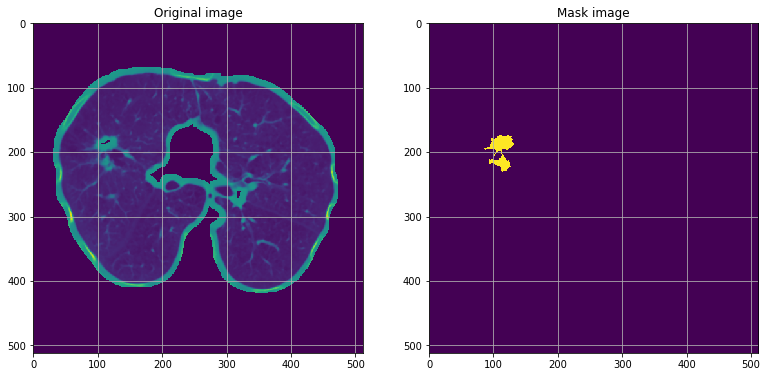

In [5]:
original = np.load(IMAGE_DIR+'/LIDC-IDRI-0332/0332_NI000_slice006.npy')
mask = np.load(MASK_DIR+'/LIDC-IDRI-0332/0332_MA000_slice006.npy')
fig,ax = plt.subplots(1,2, figsize=(13,13))
ax[0].title.set_text('Original image')
ax[0].imshow(original)
ax[0].grid()
ax[1].title.set_text('Mask image')
ax[1].imshow(mask)
ax[1].grid()
#ax[2].title.set_text('Predicted Mask image')
#ax[2].imshow(predict)
#ax[2].grid()

In [6]:
def crop_nodule(coord,image,dim=112):
    """
    Returns a cropped image of size 2*dim x 2*dim when dim. There are corner cases in the border.
    We pad the image if the coordinate is located on the corner
    
    Args:
    coord: coordinate of x,y as list or tuple. For COM the input is as (y coord, x coord)
    image: image to be cropped
    dim: 1/2 size of the image after being cropped
    
    Returns:
    Cropped Image
    
    """
    x_coord = int(coord[1])+ dim
    y_coord = int(coord[0])+ dim
    
    # pad the image
    image_pad = np.pad(image, ((dim,dim),(dim,dim)), 'constant', constant_values=0)

    return image_pad[y_coord-dim:y_coord+dim,x_coord-dim:x_coord+dim]

def gradient_transform(patch):
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

    arrx = signal.convolve2d(patch,xder,mode='same')
    arry = signal.convolve2d(patch,yder,mode='same')

    return np.hypot(arrx,arry)

def laplacian_transform(patch):
    xder = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    yder = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    arrx = signal.convolve2d(patch,xder,mode='same')
    arry = signal.convolve2d(patch,yder,mode='same')
    arrx = signal.convolve2d(arrx,yder,mode='same')
    arry = signal.convolve2d(arry,xder,mode='same')
    return np.hypot(arrx,arry)


def create_3channel(coord,image):
    patch = crop_nodule(coord,image,dim=112)
    grad_patch = gradient_transform(patch)
    lap_patch = laplacian_transform(patch)
    output = np.stack([patch,grad_patch,lap_patch],axis=2)
    return output

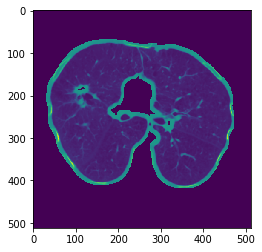

In [7]:
plt.imshow(original)

In [8]:
ex = original[100:400,100:400]

In [9]:
ex.shape

(300, 300)

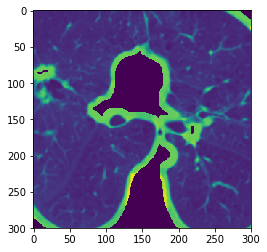

In [10]:
plt.imshow(ex)

In [8]:
test = image.extract_patches_2d(original,(100,100),1)
test = np.squeeze(test)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


In [9]:
test.shape

(100, 100)

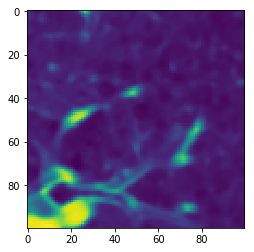

In [10]:
plt.imshow(test)

In [11]:
ndi.center_of_mass(mask)

(197.53549517966695, 111.64504820333042)

In [8]:
patch = crop_nodule(ndi.center_of_mass(mask),original)

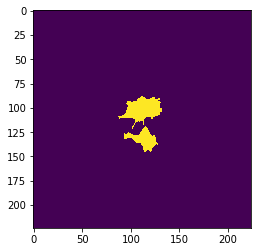

In [9]:
plt.imshow(crop_nodule(ndi.center_of_mass(mask),mask))
plt.savefig('mask.png',dpi=300)

In [11]:
rgb= create_3channel(ndi.center_of_mass(mask),original)

In [12]:
type(rgb)

numpy.ndarray

In [13]:
rgb.shape

(224, 224, 3)

In [14]:
rgb_32 = np.float32(rgb)

In [15]:
pil_image = Image.fromarray(rgb)

TypeError: Cannot handle this data type

In [14]:
rgb_32

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.2785467 , 0.94819856, 0.18372588],
        [0.28940064, 0.9331469 , 1.1548623 ],
        [0.30493292, 1.0633168 , 2.5112972 ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.23849885, 0.21321182, 0.54545265],
        [0.2340075 , 0.2969066 , 0.5114291 ],
        [0.22577332, 1.0080924 , 0.3109775 ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.22689617, 0.1046918 , 0.3586072 ],
        [0.2149192 , 0.12880379, 0.01005544],
        [0.20911786, 0.8712058 , 0.6349448 ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [15]:
rgb.dtype

dtype('float64')

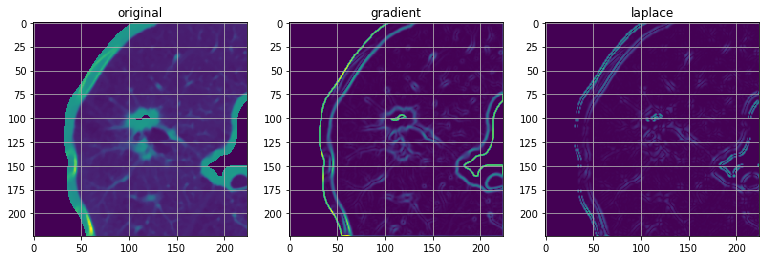

In [17]:
fig,ax = plt.subplots(1,3, figsize=(13,13))
ax[0].title.set_text('original')
ax[0].imshow(rgb[:,:,0])
ax[0].grid()
ax[1].title.set_text('gradient')
ax[1].imshow(rgb[:,:,1])
ax[1].grid()
ax[2].title.set_text('laplace')
ax[2].imshow(rgb[:,:,2])
ax[2].grid()
plt.savefig('different filter apply',dpi=300)

In [24]:
meta = pd.read_csv('meta.csv')

In [25]:
meta

,Unnamed: 0,index,patient_id,nodule_no,slice_no,original_image,mask_image,malignancy,is_cancer,is_nodule,is_clean,Segmentation_train
0,0,0,1,0,0,0001_NI000_slice000,0001_MA000_slice000,5,True,True,False,False
1,1,1,1,0,1,0001_NI000_slice001,0001_MA000_slice001,5,True,True,False,True
2,2,2,1,0,2,0001_NI000_slice002,0001_MA000_slice002,5,True,True,False,False
3,3,3,1,0,3,0001_NI000_slice003,0001_MA000_slice003,5,True,True,False,True
4,4,4,1,0,4,0001_NI000_slice004,0001_MA000_slice004,5,True,True,False,True
5,5,5,1,0,5,0001_NI000_slice005,0001_MA000_slice005,5,True,True,False,True
6,6,6,1,0,6,0001_NI000_slice006,0001_MA000_slice006,5,True,True,False,True
7,7,7,1,0,7,0001_NI000_slice007,0001_MA000_slice007,5,True,True,False,True
8,8,8,2,0,0,0002_NI000_slice000,0002_MA000_slice000,5,True,True,False,True
9,9,9,2,0,1,0002_NI000_slice001,0002_MA000_slice001,5,True,True,False,True


In [7]:
meta['original_image'].apply(lambda x: 'st/'+x)

0        st/0001_NI000_slice000
1        st/0001_NI000_slice001
2        st/0001_NI000_slice002
3        st/0001_NI000_slice003
4        st/0001_NI000_slice004
5        st/0001_NI000_slice005
6        st/0001_NI000_slice006
7        st/0001_NI000_slice007
8        st/0002_NI000_slice000
9        st/0002_NI000_slice001
10       st/0002_NI000_slice002
11       st/0002_NI000_slice003
12       st/0002_NI000_slice004
13       st/0002_NI000_slice005
14       st/0002_NI000_slice006
15       st/0002_NI000_slice007
16       st/0002_NI000_slice008
17       st/0002_NI000_slice009
18       st/0002_NI000_slice010
19       st/0002_NI000_slice011
20       st/0002_NI000_slice012
21       st/0002_NI000_slice013
22       st/0002_NI000_slice014
23       st/0002_NI000_slice015
24       st/0002_NI000_slice016
25       st/0002_NI000_slice017
26       st/0002_NI000_slice018
27       st/0002_NI000_slice019
28       st/0002_NI000_slice020
29       st/0002_NI000_slice021
                  ...          
13886   

In [54]:
clean_img = np.load('/home/LUNG_DATA/Efficient_net/clean_test/0174_CN001_slice043.npy')

In [55]:
clean_img.shape

(224, 224, 3)

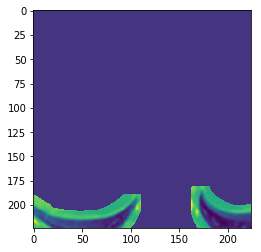

In [56]:
plt.imshow(clean_img[:,:,0])

In [57]:
np.sum(clean_img[:,:,0])

2192.304385632742